In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from gerrychain import constraints
from functools import partial
from gerrychain.tree import recursive_tree_part
import pickle
import random

In [58]:
POP_COL = "TOTPOPdp"
NUM_DISTRICTS = 14
SEN_DISTRICTS = 56
ITERS = 10000
EPS = 0.025

In [3]:
df = gpd.read_file("/cluster/tufts/mggg/jmatth03/DP/GA_bgs/GA_block_group_dp.shp")
graph = Graph.from_file("/cluster/tufts/mggg/jmatth03/DP/GA_bgs/GA_block_group_dp.shp")

In [4]:
df.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'index',
       'gisjoin', 'name_dp', 'TOTPOPdp', 'NH_HISPdp', 'NH_WHITEdp',
       'NH_BLACKdp', 'NH_AMINdp', 'NH_ASIANdp', 'NH_NHPIdp', 'NH_OTHERdp',
       'NH_2MOREdp', 'HISPdp', 'H_WHITEdp', 'H_BLACKdp', 'H_AMINdp',
       'H_ASIANdp', 'H_NHPIdp', 'H_OTHERdp', 'H_2MOREdp', 'name_sf',
       'TOTPOPsf', 'NH_HISPsf', 'NH_WHITEsf', 'NH_BLACKsf', 'NH_AMINsf',
       'NH_ASIANsf', 'NH_NHPIsf', 'NH_OTHERsf', 'NH_2MOREsf', 'HISPsf',
       'H_WHITEsf', 'H_BLACKsf', 'H_AMINsf', 'H_ASIANsf', 'H_NHPIsf',
       'H_OTHERsf', 'H_2MOREsf', 'geometry'],
      dtype='object')

In [5]:
ga_updaters = {"population" : Tally(POP_COL, alias="population"),
               "cut_edges": cut_edges,
               "TOTPOP_sf": Tally("TOTPOPsf", alias="TOTPOP_sf"),
               "WPOP_dp": Tally("NH_WHITEdp", alias="WPOP_dp"),
               "HPOP_dp": Tally("HISPdp", alias="HPOP_dp"),
               "BPOP_dp": Tally("NH_BLACKdp", alias="BPOP_dp"),
               "WPOP_sf": Tally("NH_WHITEsf", alias="WPOP_sf"),
               "HPOP_sf": Tally("HISPsf", alias="HPOP_sf"),
               "BPOP_sf": Tally("NH_BLACKsf", alias="BPOP_sf"),
               "HPOP_dp_perc": lambda p: {k: (v / p["population"][k]) for k, v in p["HPOP_dp"].items()},
               "WPOP_dp_perc": lambda p: {k: (v / p["population"][k]) for k, v in p["WPOP_dp"].items()},
               "BPOP_dp_perc": lambda p: {k: (v / p["population"][k]) for k, v in p["BPOP_dp"].items()},
               "HPOP_sf_perc": lambda p: {k: (v / p["TOTPOP_sf"][k]) for k, v in p["HPOP_sf"].items()},
               "WPOP_sf_perc": lambda p: {k: (v / p["TOTPOP_sf"][k]) for k, v in p["WPOP_sf"].items()},
               "BPOP_sf_perc": lambda p: {k: (v / p["TOTPOP_sf"][k]) for k, v in p["BPOP_sf"].items()},}

In [6]:
total_pop = sum(df[POP_COL])
ideal_pop = total_pop / NUM_DISTRICTS

In [7]:
cddict = recursive_tree_part(graph=graph, parts=range(NUM_DISTRICTS), 
                             pop_target=ideal_pop, pop_col=POP_COL, epsilon=EPS)

In [8]:
init_partition = Partition(graph, assignment=cddict, updaters=ga_updaters)

In [ ]:
ideal_pop_sen = total_pop / SEN_DISTRICTS
cddict_sen  = recursive_tree_part(graph=graph, parts=range(SEN_DISTRICTS), 
                             pop_target=ideal_pop, pop_col=POP_COL, epsilon=EPS)
init_sen_partition = Partition(graph, assignment=cddict_sen, updaters=ga_updaters)

In [ ]:
init_sen_partition.plot()

In [ ]:
min(init_partition["TOTPOP_sf"].values()),max(init_partition["TOTPOP_sf"].values())

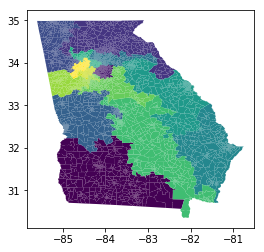

In [9]:
init_partition.plot()

In [10]:
min(init_partition["TOTPOP_sf"].values()),max(init_partition["TOTPOP_sf"].values())

(677683, 708504)

In [11]:
proposal = partial(recom, pop_col=POP_COL, pop_target=ideal_pop, epsilon=EPS, 
                   node_repeats=1)

compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]), 
                                           2*len(init_partition["cut_edges"]))

chain = MarkovChain(
        proposal,
        constraints=[
            constraints.within_percent_of_ideal_population(init_partition, EPS),
            compactness_bound],
        accept=accept.always_accept,
        initial_state=init_partition,
        total_steps=ITERS)

In [12]:
def init_chain_results():
    data = {"cutedges": np.zeros(ITERS)}
    data["TOTPOP_dp"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["TOTPOP_sf"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["WPOP_dp"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["HPOP_dp"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["BPOP_dp"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["WPOP_sf"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["HPOP_sf"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["BPOP_sf"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["HPOP_dp_perc"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["WPOP_dp_perc"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["BPOP_dp_perc"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["HPOP_sf_perc"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["WPOP_sf_perc"] = np.zeros((ITERS, NUM_DISTRICTS))
    data["BPOP_sf_perc"] = np.zeros((ITERS, NUM_DISTRICTS))
    return data

def tract_chain_results(data, part, i):
    data["cutedges"][i] = len(part["cut_edges"])
    data["TOTPOP_df"][i] = sorted(part["population"].values())
    data["TOTPOP_sf"][i] = sorted(part["TOTPOP_sf"].values())
    
    data["WPOP_dp"][i] = sorted(part["WPOP_dp"].values())
    data["HPOP_dp"][i] = sorted(part["HPOP_dp"].values())
    data["BPOP_dp"][i] = sorted(part["BPOP_dp"].values())
    data["WPOP_sf"][i] = sorted(part["WPOP_sf"].values())
    data["HPOP_sf"][i] = sorted(part["HPOP_sf"].values())
    data["BPOP_sf"][i] = sorted(part["BPOP_sf"].values())
    
    data["HPOP_dp_perc"][i] = sorted(part["HPOP_dp_perc"].values())
    data["WPOP_dp_perc"][i] = sorted(part["WPOP_dp_perc"].values())
    data["BPOP_dp_perc"][i] = sorted(part["BPOP_dp_perc"].values())
    data["HPOP_sf_perc"][i] = sorted(part["HPOP_sf_perc"].values())
    data["WPOP_sf_perc"][i] = sorted(part["WPOP_sf_perc"].values())
    data["BPOP_sf_perc"][i] = sorted(part["BPOP_sf_perc"].values())


In [13]:
chain_results = init_chain_results()


for i, part in enumerate(chain):
    chain_results["cutedges"][i] = len(part["cut_edges"])
    tract_chain_results(chain_results, part, i)
#     update_saved_parts(parts, part, ELECTS, i)

    if i % 1000 == 0:
        print("*", end="", flush=True)
print()

**********


In [63]:
graph.nodes[0]["TOTPOPsf"]

570

In [106]:
np.repeat(np.arange(2),ITERS*NUM_DISTRICTS).shape

(280000,)

array(['DP', 'SF'], dtype='<U2')

In [28]:
np.append(chain_results["BPOP_dp_perc"], chain_results["BPOP_sf_perc"])

array([0.05596615, 0.09318195, 0.12028136, ..., 0.4488006 , 0.49518615,
       0.64463048])

In [53]:
d = {"dist": np.array(list(np.arange(1,15))*ITERS*2),
     "BPOP_perc": np.append(chain_results["BPOP_sf_perc"], chain_results["BPOP_dp_perc"]),
     "HPOP_perc": np.append(chain_results["HPOP_sf_perc"], chain_results["HPOP_dp_perc"]),
     "TOTPOP": np.append(chain_results["TOTPOP_sf"], chain_results["TOTPOP_df"]),
     "DP": np.repeat(np.array(["DP", "SF"]),ITERS*NUM_DISTRICTS)}

In [54]:
df = pd.DataFrame(d)

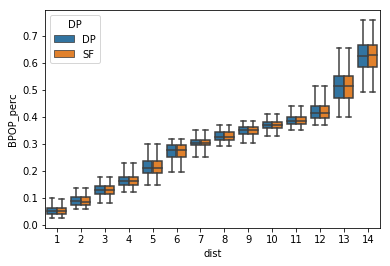

In [55]:
sns.boxplot(data=df, x="dist", y="BPOP_perc", hue="DP", showfliers=False, whis=(1,99))

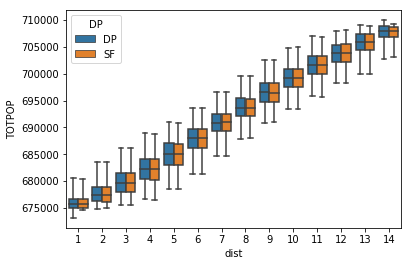

In [56]:
sns.boxplot(data=df, x="dist", y="TOTPOP", hue="DP", showfliers=False, whis=(1,99))

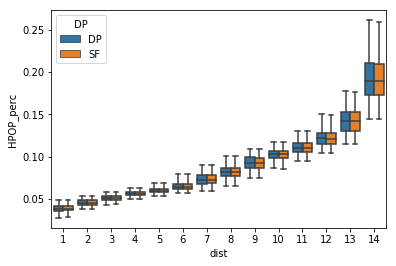

In [57]:
sns.boxplot(data=df, x="dist", y="HPOP_perc", hue="DP", showfliers=False, whis=(1,99))

In [49]:
df

,dist,BPOP_perc,TOTPOP,DP
0,1,0.056313,677683.0,DP
1,2,0.093411,679276.0,DP
2,3,0.120136,682989.0,DP
3,4,0.139590,685172.0,DP
4,5,0.248088,687670.0,DP
5,6,0.293649,690162.0,DP
6,7,0.315315,691397.0,DP
7,8,0.337994,692274.0,DP
8,9,0.379757,692829.0,DP
9,10,0.389400,695326.0,DP


[]

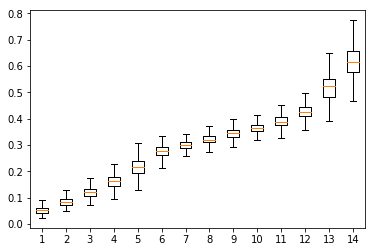

In [87]:
plt.boxplot(chain_results["BPOP_dp_perc"], showfliers=False)
plt.plot()